#Importing all required libraries

In [1]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For Modeling
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from datetime import datetime


# for feature engineering
from sklearn import linear_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
#from haversine import haversine 
from progressbar import ProgressBar
import yaml

## for text field processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import datasets, feature_extraction, decomposition
from nltk.stem.porter import PorterStemmer

import gensim
from gensim import corpora
import re
import nltk
from nltk.corpus import stopwords
#from stop_words import get_stop_words
import operator



# Importing and looking at the Data

In [1]:
# importing data 
#!wget https://www.dropbox.com/s/y5axc55jyg4k64a/Featured_data.zip

In [2]:
# Unzip the data
#!unzip /content/Featured_data.zip

In [7]:
# importing train data
train_LDA=pd.read_csv('/content/Featured_data/train_LDA.csv')

In [8]:
# importing test data
test_LDA=pd.read_csv('/content/Featured_data/train_LDA.csv')

In [9]:
train_LDA.shape , test_LDA.shape

((49999, 36), (49999, 36))

# Data Cleaning and Preprocessing

  * Combining both train and test data for data preparation

In [10]:

test_LDA['log_price']=np.nan
train_LDA['data']='train'
test_LDA['data']='test'
test_LDA=test_LDA[train_LDA.columns]
combine_data=pd.concat([train_LDA,test_LDA],axis=0)

In [11]:
combine_data.head(2)

,id,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,log_price,Description_Length,Sentiment_intensity,topic_general,Topic_utilities,Topic_Transport,Topic_listing_desc,Topic_attractions,data
0,6901257,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",6/18/2016,t,t,NaN,3/26/2012,f,7/18/2016,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0,5.010635,31.0,0.8658,0.017906,0.016000,0.021348,0.010992,0.933753,train
1,6304928,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,t,f,100%,6/19/2017,t,9/23/2017,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0,5.129899,168.0,0.9755,0.144574,0.534894,0.315791,0.000000,0.000000,train


In [12]:
# checking if null value exits
combine_data.isnull().sum()

id                            0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   292
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              21422
host_has_profile_pic        254
host_identity_verified      254
host_response_rate        24676
host_since                  254
instant_bookable              0
last_review               21366
latitude                      0
longitude                     0
name                          0
neighbourhood              9234
number_of_reviews             0
review_scores_rating      22602
thumbnail_url             11190
zipcode                    1280
bedrooms                    124
beds                        182
log_price                 49999
Description_Length            0
Sentiment_intensity           0
topic_ge

#Note
The columns which are not useful in predicting the target column i.e Price are dropped.

In [13]:
cols_to_drop=['description','name','neighbourhood','thumbnail_url','zipcode','city','longitude','latitude','host_has_profile_pic']
combine_data.drop(cols_to_drop,axis=1,inplace=True)

# Cleaning individual columns

In [14]:
#cleaning fee
combine_data['cleaning_fee'].value_counts()

True     73254
False    26744
Name: cleaning_fee, dtype: int64

In [15]:
combine_data.cleaning_fee = combine_data.cleaning_fee.astype('int64')
combine_data['cleaning_fee'].value_counts()

1    73254
0    26744
Name: cleaning_fee, dtype: int64

In [16]:
# property_type
combine_data['property_type'].value_counts()

Apartment             66226
House                 22276
Condominium            3518
Townhouse              2292
Loft                   1668
Other                   784
Guesthouse              648
Bed & Breakfast         640
Bungalow                528
Villa                   240
Dorm                    198
Guest suite             166
Camper/RV               126
In-law                   98
Cabin                    98
Hostel                   96
Timeshare                92
Boutique hotel           88
Boat                     72
Serviced apartment       32
Tent                     24
Castle                   16
Yurt                     14
Vacation home            14
Treehouse                12
Hut                      10
Chalet                    6
Earth House               4
Cave                      2
Train                     2
Parking Space             2
Lighthouse                2
Tipi                      2
Casa particular           2
Name: property_type, dtype: int64

Cleaning of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [17]:
# Replacing categories that are types of houses or apartments
combine_data.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
combine_data.loc[~combine_data.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [18]:
combine_data['property_type'].value_counts()

Apartment    67926
House        25342
Other         6730
Name: property_type, dtype: int64

# bathrooms, bedrooms and beds

In [19]:

# Missing values will be replaced with the median (to avoid strange fractions)
for col in ['bathrooms', 'bedrooms', 'beds']:
    combine_data[col].fillna(combine_data[col].median(), inplace=True)



#bed_type

In [20]:

combine_data.bed_type.value_counts()

Real Bed         97150
Futon             1036
Pull-out Sofa      806
Airbed             646
Couch              360
Name: bed_type, dtype: int64

Most listings have the same bed type so this feature can be dropped.

In [21]:
combine_data.drop('bed_type', axis=1, inplace=True)

#amenities

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [22]:
# Example of amenities listed
combine_data.amenities[:1].values

array(['{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'],
      dtype=object)

In [23]:
# Creating a set of all possible amenities
amenities_list = list(combine_data.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bath towel',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Body soap',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV charger',
 'Elevator',
 'Elevator in building',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm matress',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower & toilet',
 'Flat',
 'Flat smooth pathway to fro

In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed') 

The amenities chosen are (slashes indicate separate categories that can be combined):

* 24-hour check-in
* Air conditioning/central air conditioning
* Amazon Echo/Apple TV/DVD player/game console/Netflix/ projector and screen/smart TV (i.e. non-basic electronics)
* BBQ grill/fire pit/propane barbeque
* Balcony/patio or balcony
* Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
* Bed linens
* Breakfast
* Cable TV/TV
* Coffee maker/espresso machine
* Cooking basics
* Dishwasher /Dryer/Washer/Washer and dryer
* Elevator
* Exercise equipment/gym/private gym/shared gym
* Family/kid friendly, or anything containing 'children'
* Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
* Garden or backyard/outdoor seating/sun loungers/terrace
Host greets you
* Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
* Internet/pocket wifi/wifi
* Long term stays allowed
* Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
* Private entrance
* Safe/security system
* Self check-in
* Smoking allowed
* Step-free access/wheelchair accessible, or anything containing 'accessible'
* Suitable for events

In [24]:
combine_data.loc[combine_data['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
combine_data.loc[combine_data['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
combine_data.loc[combine_data['amenities'].str.contains('TV'), 'tv'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Elevator'), 'elevator'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
combine_data.loc[combine_data['amenities'].str.contains('parking'), 'parking'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
combine_data.loc[combine_data['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [28]:
cols_to_replace_nulls = combine_data.iloc[:,27:].columns
cols_to_replace_nulls

Index(['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq',
       'balcony', 'nature_and_views', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in', 'smoking_allowed',
       'accessible', 'event_suitable'],
      dtype='object')

In [29]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = combine_data.iloc[:,27:].columns
combine_data[cols_to_replace_nulls] = combine_data[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in combine_data.iloc[:,27:].columns:
    if combine_data[col].sum() < len(combine_data)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
combine_data.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
combine_data.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'bed_linen', 'coffee_machine', 'cooking_basics', 'outdoor_space', 'host_greeting', 'long_term_stays', 'private_entrance', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


# first_review and last_review

In [30]:
print(f"Null values in 'first_review': {round(100*combine_data.first_review.isna().sum()/len(combine_data),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*combine_data.review_scores_rating .isna().sum()/len(combine_data),1)}%")

Null values in 'first_review': 21.4%
Null values in 'review_scores_rating': 22.6%


In [31]:
combine_data.first_review = pd.to_datetime(combine_data.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
combine_data['time_since_first_review'] = (datetime(2019, 4, 9) - combine_data.first_review).astype('timedelta64[D]')

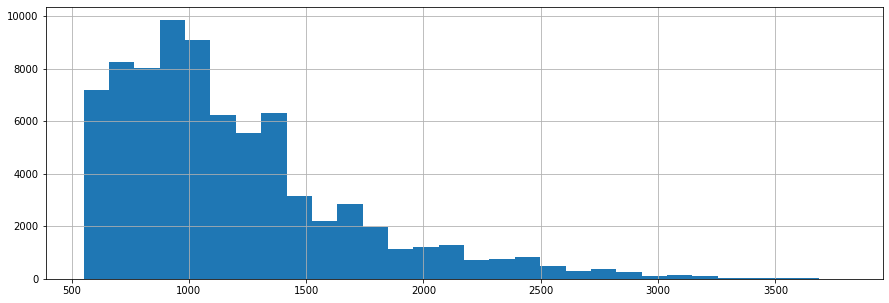

In [32]:
# Distribution of the number of days since first review
combine_data.time_since_first_review.hist(figsize=(15,5), bins=30);

In [33]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    combine_data[col] = pd.cut(combine_data[col], bins=bins, labels=labels, include_lowest=True)
    combine_data[col] = combine_data[col].astype('str')
    combine_data[col].fillna(na_label, inplace=True)

In [34]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(combine_data.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for last_review:

In [35]:
combine_data.last_review = pd.to_datetime(combine_data.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
combine_data['time_since_last_review'] = (datetime(2019, 4, 9) - combine_data.last_review).astype('timedelta64[D]')

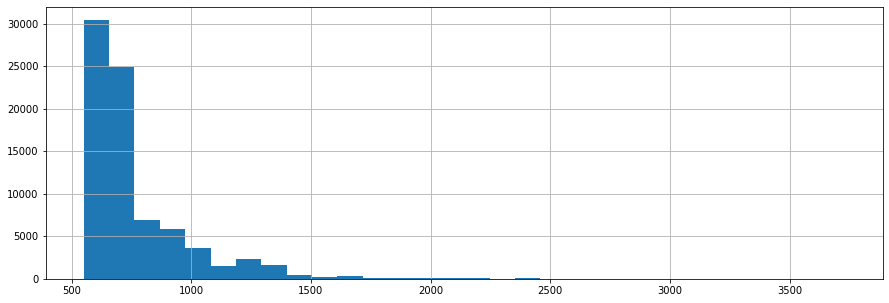

In [36]:
# Distribution of the number of days since last review
combine_data.time_since_last_review.hist(figsize=(15,5), bins=30);

In [37]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(combine_data.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [38]:
# Dropping last_review and first_review- 
combine_data.drop(['last_review','first_review'], axis=1, inplace=True)

#review_scores_rating

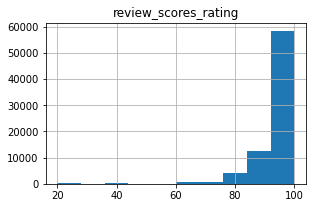

In [39]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(combine_data.columns[combine_data.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    combine_data[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together

In [40]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

#host_since

In [41]:
# Converting to datetime
combine_data.host_since = pd.to_datetime(combine_data.host_since) 

# Calculating the number of days
combine_data['host_days_active'] = (datetime(2019, 4, 9) - combine_data.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(combine_data['host_days_active'].mean(),0))
print("Median days as host:", combine_data['host_days_active'].median())

# Replacing null values with the median
combine_data.host_days_active.fillna(combine_data.host_days_active.median(), inplace=True)

Mean days as host: 1723.0
Median days as host: 1654.0


In [42]:
combine_data.drop('host_since',axis=1,inplace=True)

#host_response_rate

In [43]:
# Removing the % sign from the host_response_rate string and converting to an integer
combine_data.host_response_rate = combine_data.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(combine_data['host_response_rate'].mean(),0))
print("Median host response rate:", combine_data['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((combine_data.host_response_rate == 100.0).sum()/combine_data.host_response_rate.count())*100,1)}%")

Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 77.3%


In [44]:
# Bin into four categories
combine_data.host_response_rate = pd.cut(combine_data.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
combine_data.host_response_rate = combine_data.host_response_rate.astype('str')

# Replace nulls with 'unknown'
combine_data.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
combine_data.host_response_rate.value_counts()

100%       58248
unknown    24676
50-89%      9890
90-99%      4338
0-49%       2846
Name: host_response_rate, dtype: int64

In [45]:
data_EDA=combine_data.copy()

# converting categorical column into numerical

In [46]:
cat_var=combine_data.select_dtypes(['object']).columns

cat_var

Index(['property_type', 'room_type', 'cancellation_policy',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'review_scores_rating', 'data', 'time_since_first_review',
       'time_since_last_review'],
      dtype='object')

In [47]:
cat_vars=['property_type', 'room_type', 'cancellation_policy',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'review_scores_rating', 'time_since_first_review',
       'time_since_last_review']

In [48]:
# for cleaned train data
for col in cat_vars:
    dummy=pd.get_dummies(combine_data[col],drop_first=True,prefix=col)
    combine_data=pd.concat([combine_data,dummy],axis=1)
    del combine_data[col]
    print(col)
del dummy

property_type
room_type
cancellation_policy
host_identity_verified
host_response_rate
instant_bookable
review_scores_rating
time_since_first_review
time_since_last_review


# Data cleaning is done , Now we are separating train and test data for model building process

In [49]:
train_LDA=combine_data[combine_data['data']=='train']
del train_LDA['data']
test_LDA=combine_data[combine_data['data']=='test']
test_LDA.drop(['log_price','data'],axis=1,inplace=True)

# Exporting train and test data for modelling building process

In [50]:
train_LDA.to_csv('cleaned_train_data.csv',index=False)
test_LDA.to_csv('cleaned_test_data.csv',index=False)